In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os

drive_base = '/content/drive/MyDrive/cat_and_dogs'

# Liệt kê các folder con trong dataset
if os.path.exists(drive_base):
    print("Các folder con trong cat_and_dogs:")
    print(os.listdir(drive_base))
else:
    print("Folder dataset không tồn tại. Kiểm tra lại đường dẫn!")


Các folder con trong cat_and_dogs:
['dataset']


In [ ]:
import os

base_path = '/content/drive/MyDrive/cat_and_dogs/dataset'

print("Các folder con trong dataset:")
print(os.listdir(base_path))

print("training_set:", os.listdir(os.path.join(base_path, 'training_set')))
print("test_set:", os.listdir(os.path.join(base_path, 'test_set')))


Các folder con trong dataset:
['single_prediction', 'test_set', 'training_set']
training_set: ['cats', 'dogs']
test_set: ['cats', 'dogs']


In [ ]:
# ========================== TRAIN EFFICIENTNETB0 ĐÚNG CHUẨN ==========================
!pip install -q tensorflow

import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.efficientnet import EfficientNetB0, preprocess_input

# ---------------- 1. Mount Drive ----------------
from google.colab import drive
drive.mount('/content/drive')

# ---------------- 2. Đường dẫn dataset ----------------
base_path = '/content/drive/MyDrive/cat_and_dogs/dataset'
train_path = os.path.join(base_path, 'training_set')
test_path = os.path.join(base_path, 'test_set')

print("Folders trong training_set:", os.listdir(train_path))
print("Folders trong test_set:", os.listdir(test_path))

# ---------------- 3. Data Augmentation & Preprocessing ----------------
IMG_SIZE = 224
BATCH_SIZE = 16

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,  # dùng preprocess_input của EfficientNet
    validation_split=0.2,                     # 20% validation
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    train_path,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

# ---------------- 4. Build EfficientNetB0 ----------------
base_model = EfficientNetB0(
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    weights='imagenet'
)
base_model.trainable = False  # freeze base

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(2, activation='softmax')(x)  # 2 class: cats & dogs

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# ---------------- 5. Train model ----------------
EPOCHS = 5
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS
)

# ---------------- 6. Save model vào Drive ----------------
model_save_path = os.path.join(base_path, "cats_vs_dogs_efficientnetB0_preprocessed.h5")
model.save(model_save_path)
print("Model đã được lưu tại:", model_save_path)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Folders trong training_set: ['cats', 'dogs']
Folders trong test_set: ['cats', 'dogs']
Found 6400 images belonging to 2 classes.
Found 1600 images belonging to 2 classes.
Epoch 1/5
400/400 ━━━━━━━━━━━━━━━━━━━━ 168s 371ms/step - accuracy: 0.9644 - loss: 0.0893 - val_accuracy: 0.9919 - val_loss: 0.0253
Epoch 2/5
400/400 ━━━━━━━━━━━━━━━━━━━━ 107s 268ms/step - accuracy: 0.9844 - loss: 0.0415 - val_accuracy: 0.9944 - val_loss: 0.0198
Epoch 3/5
400/400 ━━━━━━━━━━━━━━━━━━━━ 107s 267ms/step - accuracy: 0.9888 - loss: 0.0290 - val_accuracy: 0.9912 - val_loss: 0.0242
Epoch 4/5
400/400 ━━━━━━━━━━━━━━━━━━━━ 106s 265ms/step - accuracy: 0.9938 - loss: 0.0157 - val_accuracy: 0.9937 - val_loss: 0.0267
Epoch 5/5
400/400 ━━━━━━━━━━━━━━━━━━━━ 106s 265ms/step - accuracy: 0.9935 - loss: 0.0176 - val_accuracy: 0.9900 - val_loss: 0.0318


Model đã được lưu tại: /content/drive/MyDrive/cat_and_dogs/dataset/cats_vs_dogs_efficientnetB0_preprocessed.h5


Model đã được load!
Tìm thấy 2 ảnh để dự đoán.
1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step


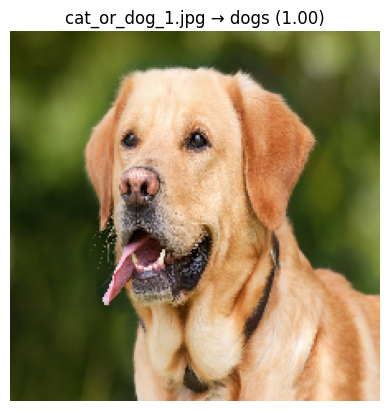

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


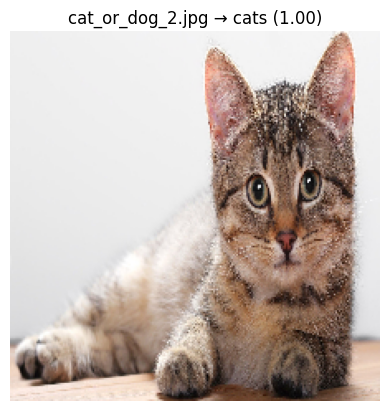

In [ ]:
# ========================== PREDICT VÀ HIỂN THỊ ẢNH ==========================
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.efficientnet import preprocess_input

# ---------------- 1. Đường dẫn model và folder prediction ----------------
base_path = '/content/drive/MyDrive/cat_and_dogs/dataset'
model_path = os.path.join(base_path, "cats_vs_dogs_efficientnetB0_preprocessed.h5")
single_pred_path = os.path.join(base_path, "single_prediction")

# ---------------- 2. Load model ----------------
model = load_model(model_path)
print("Model đã được load!")

# ---------------- 3. Lấy danh sách ảnh ----------------
img_files = [f for f in os.listdir(single_pred_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
print(f"Tìm thấy {len(img_files)} ảnh để dự đoán.")

# ---------------- 4. Class mapping ----------------
class_indices = {'cats': 0, 'dogs': 1}  # giống class generator
inv_class_indices = {v: k for k, v in class_indices.items()}

# ---------------- 5. Predict và hiển thị ----------------
IMG_SIZE = 224

for img_file in img_files:
    img_path = os.path.join(single_pred_path, img_file)
    img = image.load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)

    preds = model.predict(x)
    class_id = np.argmax(preds, axis=1)[0]
    class_name = inv_class_indices[class_id]
    confidence = preds[0][class_id]

    # Hiển thị ảnh kèm label dự đoán và xác suất
    plt.imshow(img)
    plt.title(f"{img_file} → {class_name} ({confidence:.2f})")
    plt.axis('off')
    plt.show()
